<a href="https://colab.research.google.com/github/carlos-314/carlos-314.github.io/blob/main/practica_MIAX10_parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="#CA3532"><h1 align="left">Inteligencia Artificial Aplicada a los Mercados Financieros (MIAX-10)</h1></font>
<font color="#5b5a59"><h2 align="left">Práctica sobre Redes Neuronales - Parte 2</h2></font>

En esta segunda parte de la práctica se propone construir una red neuronal que aprenda a jugar al videojuego [snake](https://www.google.com/fbx?fbx=snake_arcade) de manera supervisada, a partir de un conjunto de jugadas de ejemplo. El snake es un videojuego clásico de los años 70 en el que el jugador controla una serpiente y trata de comer todas las manzanas posibles evitando chocarse con su propia cola o los límites del escenario de juego. Cada vez que la serpiente se come una manzana, su cola crece, aumentando la dificultad del juego.

En este guión te contamos cómo implementar el modelo, paso a paso.



*Versión 1, actualizada el 01-06-2023*



In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
from enum import IntEnum
from collections import namedtuple

# Descripción de los datos

Lo primero que vamos a hacer es cargar los datos que usaremos para entrenar la red. Están en los ficheros ``dataset_x.npy`` y ``dataset_y.npy`` que acompañan a este enunciado. El primero contiene un conjunto de situaciones de partida, que incluyen la disposición del tablero y la dirección en la que se mueve la serpiente. El segundo contiene la acción a tomar en cada una de las situaciones anteriores.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Cambia esta ruta para acceder al repositorio compartido
# Si no sabes montarlo para que funcione, revisa la primera clase con Christian 
# de redes neuronales

%cd /content/drive/MyDrive/miax-10/data/snake_training/

In [ ]:
x = np.load('dataset_x.npy')
y = np.load('dataset_y.npy')

print(x.shape)
print(y.shape)

In [ ]:
# Volvemos a MyDrive para poder trabajar en local
%cd /content/drive/MyDrive/

Hay un total de ``271696`` situaciones de partida en el fichero ``dataset_x.npy``, cada una descrita por un vector de ``769`` componentes. Las primeras ``768`` componentes de este vector describen la disposición del tablero (de dimensiones ``24x32``). Cada una de las casillas del tablero puede tomar los siguientes valores:

- ``0``: casilla vacía
- ``1``: casilla ocupada por la cabeza de la serpiente
- ``2``: casilla ocupada por algún segmento del cuerpo de la serpiente
- ``3``: casilla ocupada por la manzana

La última componente indica la dirección en la que se está moviendo la serpiente, y puede ser cualquiera de las siguientes:

- ``0``: la serpiente se mueve hacia la derecha
- ``1``: la serpiente se mueve hacia arriba
- ``2``: la serpiente se mueve hacia la izquierda
- ``3``: la serpiente se mueve hacia abajo

Finalmente, el fichero ``dataset_y.npy`` contiene la siguiente dirección en la que se debe mover la serpiente, usando la misma codificación. 

A continuación se muestra, a modo de ejemplo, la disposición del tablero y las direcciones actual y siguiente para el ejemplo ``10214`` del fichero. Fíjate cómo se obtiene el tablero haciendo ``reshape`` y transponiendo la matriz resultante.

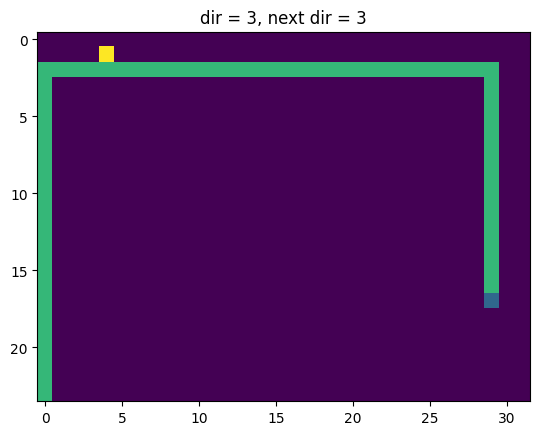

In [ ]:
ix = 10214

board = x[ix, :-1].reshape(32, 24).transpose()
direction = x[ix, -1]
next = y[ix]

plt.figure()
plt.imshow(board)
plt.title(f"dir = {direction}, next dir = {next}")
plt.show()

# Construcción del modelo

La clase SnakeModel definida a continuación representa un modelo de jugador basado en una red neuronal. El constructor recibe los datos de entrenamiento, ``x`` e ``y``, en el mismo formato descrito antes. Para implementar tu propio jugador debes modificar exclusivamente los métodos ``preprocess`` y ``create_keras_model``.

El método ``preprocess`` debe preparar los datos para la red neuronal. Lo mínimo es transformar los datos de salida, ``y``, en una nueva variable que describa la acción a realizar de manera relativa al movimiento actual de la serpiente, con los valores:

- ``0``: girar a la derecha
- ``1``: seguir recto
- ``2``: girar a la izquierda

Esto ya te lo damos hecho y no lo debes cambiar, pues el código que usaremos para probar tu jugador espera como salida las probabilidades para estas tres acciones. Por otra parte, aunque en el ejemplo no hacemos ninguna transformación sobre los datos en ``x``, es razonable que un buen preprocesado mejore considerablemente los resultados. En particular, sería deseable que todas las posiciones del tablero fuesen relativas a la cabeza de la serpiente.  

El método ``create_keras_model`` crea y compila un modelo de Keras cuya entrada serán los datos, ``x``, procesados por el método anterior y cuya salida serán tres probabilidades, asociadas a las acciones girar a la derecha, seguir recto y girar a la izquierda, respectivamente. Se incluye un ejemplo de red que puedes modificar para conseguir un buen resultado.

In [ ]:
class SnakeModel:
  def __init__(self, data_x, data_y):
    self.data_x, self.data_y = self.preprocess(data_x, data_y)
    
    self.keras_model = self.create_keras_model()

  def create_keras_model(self):
    n_in = self.data_x.shape[1]
    n_out = len(np.unique(self.data_y))

    #---------------------------------------------------------------------------
    # TO-DO modifica el modelo de Keras como consideres
    #---------------------------------------------------------------------------
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(n_in,)))
    model.add(keras.layers.Dense(64, activation="relu"))
    model.add(keras.layers.Dense(3, activation="softmax"))
    model.compile(optimizer=keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['acc'])
    #---------------------------------------------------------------------------
    
    return model

  def preprocess(self, x, y):
    new_y = (y - x[:, -1] + 5) % 4

    #---------------------------------------------------------------------------
    # TO-DO aplica las transformaciones que consideres necesarias a la 
    # variable x
    #---------------------------------------------------------------------------
    new_x = x
    #---------------------------------------------------------------------------
    
    return new_x, new_y

  def fit(self, num_epochs=100, batch_size=64):
    self.keras_model.fit(self.data_x, self.data_y, epochs=num_epochs, batch_size=batch_size)

  def predict(self, x):
    return self.keras_model.predict(x, verbose=0)

  def save(self, path, nombre):
    self.keras_model.save_weights(path + nombre)

  def load(self, path, nombre):
    self.keras_model.load_weights(path + nombre)

Una vez definida la clase, la instanciamos para crear un jugador:

In [ ]:
player = SnakeModel(x, y)

A continuación mostramos el modelo de Keras para el jugador:

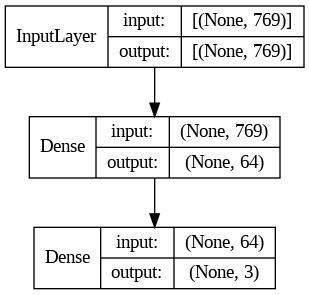

In [ ]:
tf.keras.utils.plot_model(player.keras_model, show_shapes=True, show_layer_names=False)

Y lo entrenamos durante 10 épocas llamando al método ``fit``:

In [ ]:
player.fit(num_epochs=10)

In [ ]:
path = "/content/drive/MyDrive/mi_modelo_snake/" # Cambia la ruta para que se guarde en tu drive

In [ ]:
player.save(path, 'modelo_001') # Dale el nombre que quieras al modelo

# Probando el modelo en partidas reales

Una vez entrenado, podemos ver el desempeño de nuestro modelo cuando se enfrenta a partidas reales. La siguiente celda implementa el juego (código basado en https://github.com/patrickloeber/snake-ai-pytorch).

In [ ]:
class DotType(IntEnum):
    EMPTY = 0
    SNAKE_HEAD = 1
    SNAKE_BODY = 2
    APPLE = 3

class Direction(IntEnum):
    RIGHT = 0
    UP = 1
    LEFT = 2
    DOWN = 3
    
Point = namedtuple('Point', 'x, y')

class Board:
    def __init__(self, w=32, h=24):
        self.w = w 
        self.h = h 
        self.board = np.zeros((self.w, self.h), dtype=np.uint8)

    def _get_coordinates(self, dot):
        return (dot.x, dot.y)

    def generate(self, head, direction, snake, apple):
        self.board *= 0

        for dot in snake:
            self.board[self._get_coordinates(dot)] = DotType.SNAKE_BODY
        self.board[self._get_coordinates(head)] = DotType.SNAKE_HEAD
        self.board[self._get_coordinates(apple)] = DotType.APPLE

        return np.concatenate((self.board.reshape(-1), np.array([direction])), axis=0)

class SnakeGame:
    def __init__(self, player, w=32, h=24):
        self.w = w
        self.h = h
        self.player = player

        self.direction = Direction.RIGHT
        self.last_turn = Direction.RIGHT
        
        self.head = Point(self.w//2, self.h//2)
        self.snake = [self.head, Point(self.head.x-1, self.head.y), Point(self.head.x-2, self.head.y)]

        self.board = Board(w, h)
        
        self.score = 0
        self.food = None
        self._place_food()
       
    def _place_food(self):
        x = random.randint(0, self.w - 1) 
        y = random.randint(0, self.h - 1)
        self.food = Point(x, y)
        if self.food in self.snake:
            self._place_food()
        
    def play_step(self):
        # 1. get next move
        data_x = self.board.generate(self.head, self.direction, self.snake, self.food)
        self.direction = self._get_next_direction(data_x)
        
        # 2. move
        self._move(self.direction) 
        self.snake.insert(0, self.head)
        
        # 3. check if game over
        game_over = False
        if self._is_collision():
            game_over = True
            return game_over, self.score
            
        # 4. place new food or just move
        if self.head == self.food:
            self.score += 1
            self._place_food()
        else:
            self.snake.pop()
        
        # 5. return game over and score
        return game_over, self.score
    
    def _is_collision(self):
        # hits boundary
        if self.head.x > (self.w - 1) or self.head.x < 0 or self.head.y > (self.h - 1) or self.head.y < 0:
            return True
        # hits itself
        if self.head in self.snake[1:]:
            return True
        
        return False
        
    def _get_next_direction(self, x):
        xnew, _ = self.player.preprocess(x[None, :], np.zeros((1,)))
        probs = self.player.predict(xnew)
        ix = np.argmax(probs)
        new_direction = (self.direction + 3 + ix) % 4
        return new_direction

    def _move(self, direction):
        x = self.head.x
        y = self.head.y
        if direction == Direction.RIGHT:
            x += 1
        elif direction == Direction.LEFT:
            x -= 1
        elif direction == Direction.DOWN:
            y += 1
        elif direction == Direction.UP:
            y -= 1
            
        self.head = Point(x, y)

Para probar nuestro modelo instanciamos la clase ``SnakeGame``, pasando el jugador al constructor, y realizamos algunas jugadas:

In [ ]:
path = "/content/drive/MyDrive/mi_modelo_snake/" # Cambia la ruta para que se guarde en tu drive
player = SnakeModel(x, y)
player.load(path, 'modelo_001') # Usa el nombre del modelo que hayas guardado previamente
game = SnakeGame(player=player)

scores = []
boards = []
max_iters = 200 # Cambia el número de iteraciones máximas si lo ves necesario Esta es una ejecución para ti
for iter in range(max_iters):
    game_over, score = game.play_step()

    data = game.board.generate(game.head, game.direction, game.snake, game.food)
    board = data[:-1].reshape(32, 24).transpose()
    boards.append(board)
    scores.append(score)

    print(f"iter = {iter}, score = {score}")
    iter += 1

    if game_over == True:
        break
    
print('Final Score', score)

Podemos hacer una animación para visualizar mejor los resultados:

In [ ]:
def animate_func(num):
    ax.clear()  
    ax.imshow(boards[num], animated=True)
    ax.set_title(f"iter = {num}, score = {scores[num]}")

fig = plt.figure()
ax = plt.axes()
line_ani = animation.FuncAnimation(fig, animate_func, interval=100, frames=len(boards))

f = "animation.gif"
writer = animation.PillowWriter(fps=20)
line_ani.save(path + f, writer=writer)    

La celda anterior creará un fichero gif animado con un contenido similar a este (el resultado final dependerá de la ejecución):

![](https://drive.google.com/uc?id=1aLSwHNZs-63VkzSlRo5G8sMrfsUH_3HD)

No es ninguna maravilla, aunque al menos la serpiente no se choca. No te desanimes, con un poco de trabajo es posible conseguir resultados bastante mejores, como los de este ejemplo:

![](https://drive.google.com/uc?id=1BoudUDMbtM3VBTR0XDwHNt__2nrbgLlG)

# Objetivo de la práctica

El objetivo de la práctica consiste en modificar las funciones de la clase ```SnakeModel``` , concretamente los métodos ```create_keras_model``` y ```preprocess```, para conseguir superar los siguientes apartados:

* Comerse 5 manzanas en 1.000 iteraciones. <font color="#CA3532">[2 Puntos]</font>

* Comerse 20 manzanas en 1.000 iteraciones. <font color="#CA3532">[2 Puntos]</font>

* Generalizar a tableros de tamaño diferente. <font color="#CA3532">[2 Puntos]</font>

**Requisitos para puntuar el ejercicio**:

1. El modelo solamente puede utilizar las capas de Keras vistas en clase. 

2. No se pueden utilizar técnicas de aprendizaje por refuerzo. 

**Importante**: Se evaluará con una puntuación de 0 aquellos modelos que utilicen otro tipo de capas, como, por ejemplo, las convolucionales. Si alguien tiene dudas con qué capas son válidas, preguntar a Christian por email: christian.oliva@uam.es. Sucederá de forma equivalente si se utilizan técnicas de aprendizaje por refuerzo.

**Observación**: La puntuación de comer manzanas se calculará de forma proporcional al score promedio, es decir, según la siguiente ecuación:

$$nota\left(x\right)\ =\ \min\left(\max\left(0,\ \frac{2x}{5}\right),\ 2\right)+\min\left(\max\left(0,\ \frac{2\left(x-5\right)}{15}\right),2\right)$$

donde $x$ es el score promedio de 10 partidas diferentes.

*Ejemplo: Si has obtenido un score de 7.4 en 10 partidas, tu nota será: 2.32*

**Observación**: Si en alguna ejecución, el modelo se choca antes de las 1000 iteraciones, no será penalizado y contará el score que haya obtenido hasta entonces.

In [ ]:
def nota(x):
  nota_parte_1 = np.min([np.max([0, 2*x/5]), 2])
  print("Comerse 5 manzanas:", np.around(nota_parte_1, decimals=2))
  nota_parte_2 = np.min([np.max([0, 2*(x-5)/15]), 2])
  print("Comerse 20 manzanas:", np.around(nota_parte_2, decimals=2))
  return np.around(nota_parte_1 + nota_parte_2, decimals=2)

In [ ]:
nota(7.4)

Comerse 5 manzanas: 2.0
Comerse 20 manzanas: 0.32


2.32

<font color="#CA3532">[+0.5 punto extra]</font> Este ejercicio sumará, de forma proporcional, hasta medio punto extra a la nota según el score que el profesor obtenga utilizando tu modelo con 10 partidas diferentes dejando tiempo ilimitado a la partida. El profesor se encargará de implementar un mecanismo para evitar bucles infinitos si los hubiese.

**Observaciones**: 

* Este ranking extra sumará hasta un +0.5 en la nota final, que servirá para corregir aquellos errores que se hayan cometido en otros ejercicios. 

* Aquel que tenga una nota >10 se quedará con el 10.

* Aquel que obtenga un 0 en este punto extra (sea el peor score) seguirá teniendo la posibilidad de obtener la nota máxima de 10. Este punto es un +0.5, dándote la posibilidad de llegar hasta un 10.5. No te dejará la nota sobre 9.5.

**¿Qué hay que entregar?**

* Este notebook con la construcción del modelo actualizada, incluido el método de preprocesamiento.

* Los pesos del modelo entrenado. Para ello, debéis utilizar el método ```save``` de la clase ```SnakeModel```. Debéis entregar los pesos generados en un zip. **OJO**: Asegúrate de que sea compatible con el método ```load``` que también os damos.

Se debe entregar todo en un único fichero comprimido (ZIP, RAR, etc.).

La evaluación de la puntuación se realizará de forma similar al siguiente código:

In [ ]:
# Es posible que la evaluación del profesor modifique ligeramente este código para evitar bucles infinitos, probar
# otros tableros de tamaño diferentes o evaluar para el ranking.

path = "/content/drive/MyDrive/mi_modelo_snake/" # El profesor adaptará el path para seleccionar el modelo correspondiente
name = "modelo_001" # El profesor adaptará el path para seleccionar el modelo correspondiente

scores_avg = []
for i in range(10):
  player = SnakeModel(x, y)
  player.load(path, name)
  game = SnakeGame(player=player)

  scores = []
  boards = []
  max_iters = 1000
  for iter in range(max_iters):
      game_over, score = game.play_step()

      data = game.board.generate(game.head, game.direction, game.snake, game.food)
      board = data[:-1].reshape(32, 24).transpose()
      boards.append(board)
      scores.append(score)

      print(f"iter = {iter}, score = {score}")
      iter += 1

      if game_over == True:
          break
      
  print('['+str(i+1)+'] Final Score', score)
  scores_avg.append(score)

print("SCORE FINAL:")
print(np.mean(scores_avg), "+-", np.std(scores_avg))